In [438]:
import numpy as  np
import pandas as pd
import matplotlib.pyplot as plt
# from scipy.io import wavfile
import os
import seaborn as sns
import random
import IPython.display
import librosa
from sklearn.model_selection import train_test_split
import torchaudio.transforms as transforms
# import torchaudio
from sklearn.preprocessing import LabelEncoder, StandardScaler
import tensorflow as tf
import tensorflow.keras.layers as L

from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, ZeroPadding2D,Flatten, BatchNormalization, AveragePooling2D, Dense, Activation, Add 
from tensorflow.keras.models import Model
from tensorflow.keras import activations
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras.regularizers import l1_l2

from tensorflow.python.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.python.keras import backend as K

In [2]:
config = tf.compat.v1.ConfigProto( device_count = {'GPU': 1 , 'CPU': 6} )
sess = tf.compat.v1.Session(config=config) 
K.set_session(sess)

In [362]:
audios = []
labels = []
audio_files = os.listdir('Crema')
for file in audio_files:
    labels.append(file.split('_')[2])
    # fs,data = wavfile.read(os.path.join('Crema',file))
    data, fs = librosa.load(os.path.join('Crema',file),sr=None,duration=2.5,offset=0.3)
    audios.append([data,fs])
    

In [392]:
aud = []
for audio,fs in audios:
    audio = librosa.util.fix_length(audio, size=35000)
    aud.append([audio,fs])

In [393]:
audios= aud

In [288]:
# def pad(audios):
#     max_len =  max([i.size for i,_ in audios])
#     padded_list = []
#     for l,fs in audios:
#         if not l.size == max_len:
#             padded_list.append([np.pad(l, (0, max_len-l.size), 'constant'),fs])
#         else:
#             padded_list.append([l,fs])
#     return padded_list


In [289]:
# audios = pad(audios)

In [394]:
print(len(labels))
print(len(audios))

7442
7442


In [395]:
audios[1000][0].shape

(35000,)

In [396]:
set(labels)

{'ANG', 'DIS', 'FEA', 'HAP', 'NEU', 'SAD'}

In [397]:
fs_list = [x for _,x in audios]
set(fs_list) # all files have a sample rate of 16kHz

{16000}

,data,label
0,"[[0.0006713867, 0.0006713867, 0.00048828125, 0...",ANG
1,"[[0.008575439, 0.008636475, 0.009094238, 0.009...",DIS
2,"[[3.0517578e-05, -0.000579834, -0.0010070801, ...",FEA
3,"[[0.004699707, 0.0038452148, 0.0040283203, 0.0...",HAP
4,"[[0.0045776367, 0.0049438477, 0.0043029785, 0....",NEU
...,...,...
7437,"[[0.0020751953, 0.0020446777, 0.002166748, 0.0...",DIS
7438,"[[-0.004119873, -0.0042419434, -0.004272461, -...",FEA
7439,"[[-0.0035705566, -0.0033569336, -0.0028381348,...",HAP
7440,"[[-0.00894165, -0.008422852, -0.008148193, -0....",NEU


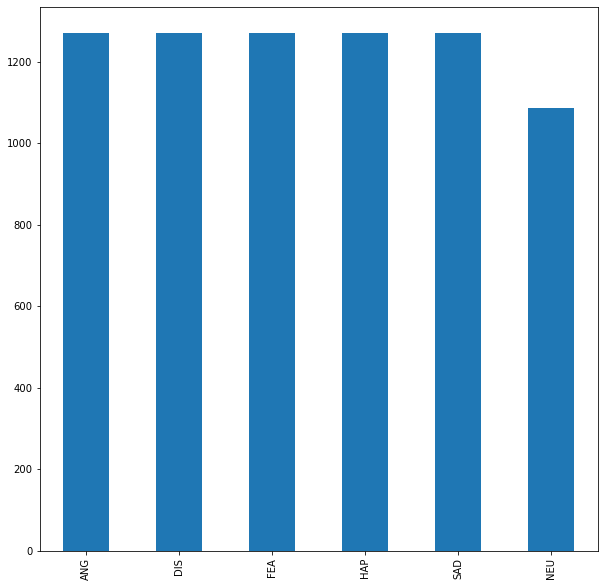

In [398]:
df = pd.concat([pd.Series(audios,name='data'),pd.Series(labels,name='label')],axis=1)
df['label'].value_counts().plot(kind='bar',figsize=(10,10))
df

In [399]:
labels[5]

'SAD'

In [400]:
emotions = {'ANG':'Angry','SAD':'Sad','NEU':'Neutral','HAP':'Happy','FEA':'Fear','DIS':'Disgust'}
colors = {'ANG':'red','SAD':'navy','NEU':'black','HAP':'yellow','FEA':'purple','DIS':'green'}

def load_audio(df,emotion):

    audios = list(df[df['label'] == emotion]['data'])
    idx = random.randint(0,len(audios)-1) # choosing a random file of that emotion
    audio = audios[idx][0]
    fs = audios[idx][1]
    duration = len(audio)/fs

    time = np.arange(0,duration,1/fs) # time vector

    plt.figure(figsize=(16,8))
    plt.plot(time,audio,color=colors[emotion])
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.title(emotions[emotion] + ' Waveform')
    plt.grid(color = 'green', linestyle = '--', linewidth = 0.5)
    plt.show()
    return audio, fs

In [401]:
def create_spectrogram(data, fs, emotion):
    # stft function converts the data into short term fourier transform
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for audio with {} emotion'.format(emotion), size=15)
    librosa.display.specshow(Xdb, sr=fs, x_axis='time', y_axis='hz')
    plt.colorbar()

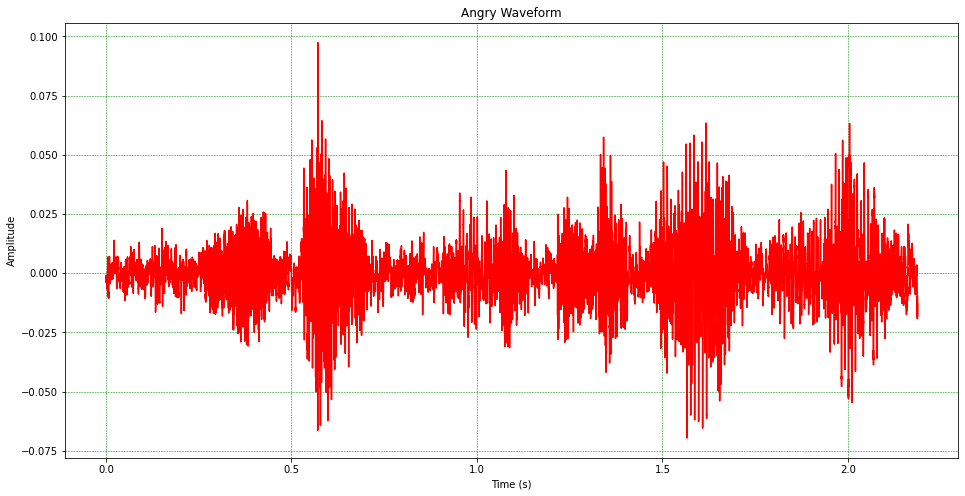

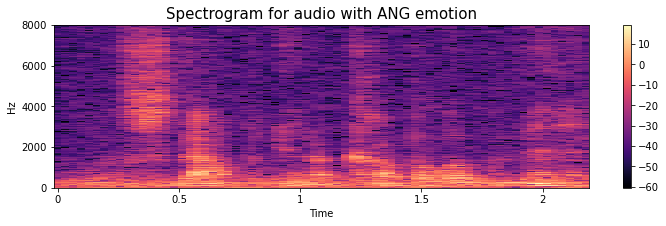

In [402]:
# ANGRY
audio,fs = load_audio(df,'ANG')
create_spectrogram(audio,fs,'ANG')
IPython.display.Audio(audio,rate=fs)


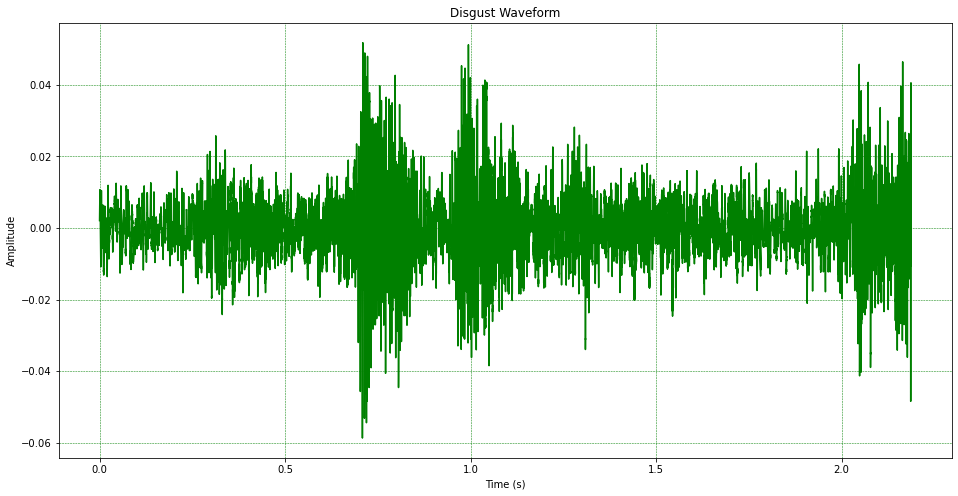

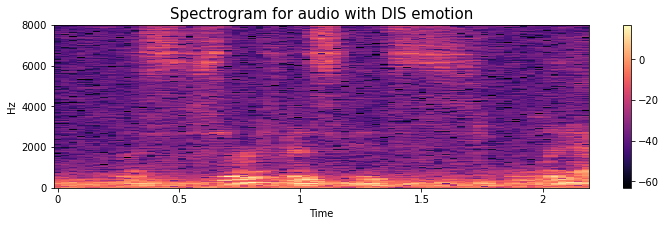

In [403]:
# DISGUSTED 
audio,fs = load_audio(df,'DIS')
create_spectrogram(audio,fs,'DIS')
IPython.display.Audio(audio,rate=fs)


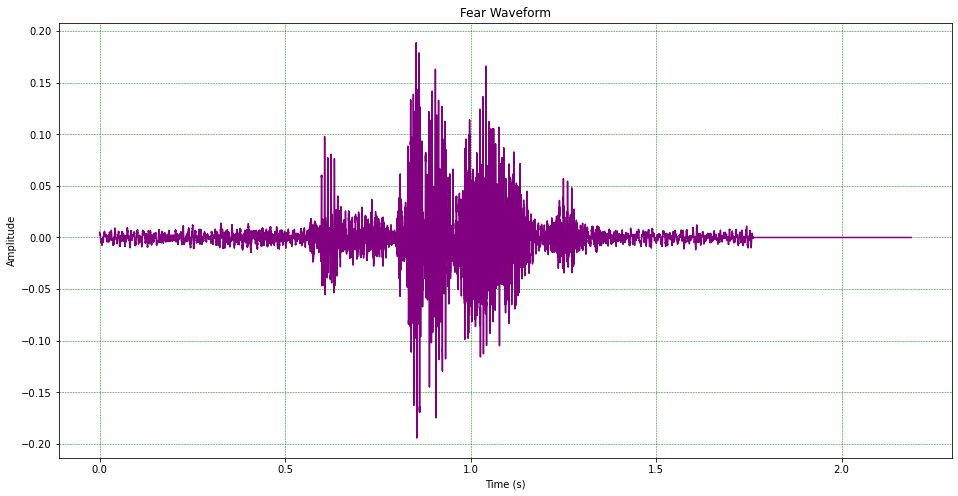

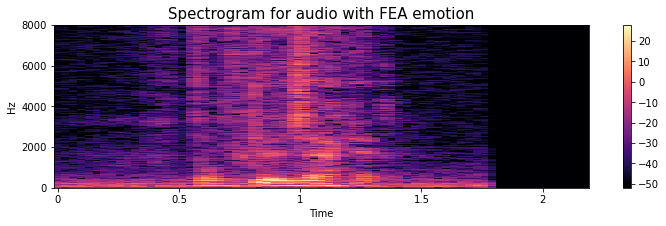

In [404]:
# FEAR
audio,fs = load_audio(df,'FEA')
create_spectrogram(audio,fs,'FEA')
IPython.display.Audio(audio,rate=fs)


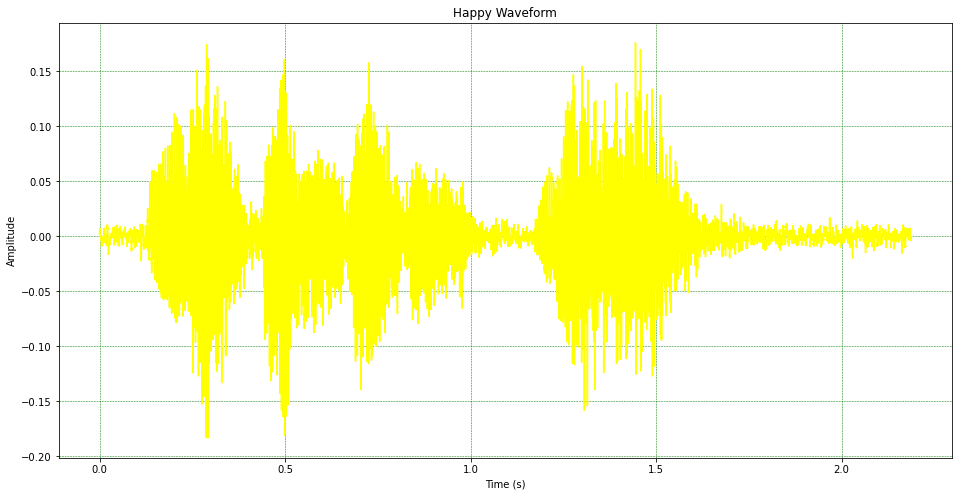

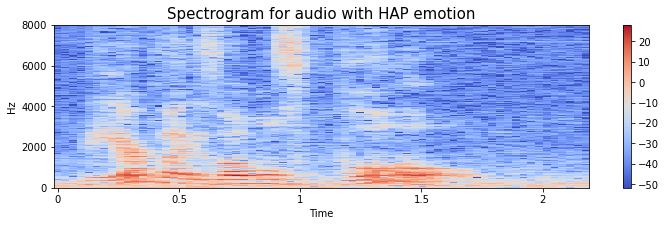

In [405]:
# HAPPY
audio,fs = load_audio(df,'HAP')
create_spectrogram(audio,fs,'HAP')
IPython.display.Audio(audio,rate=fs)


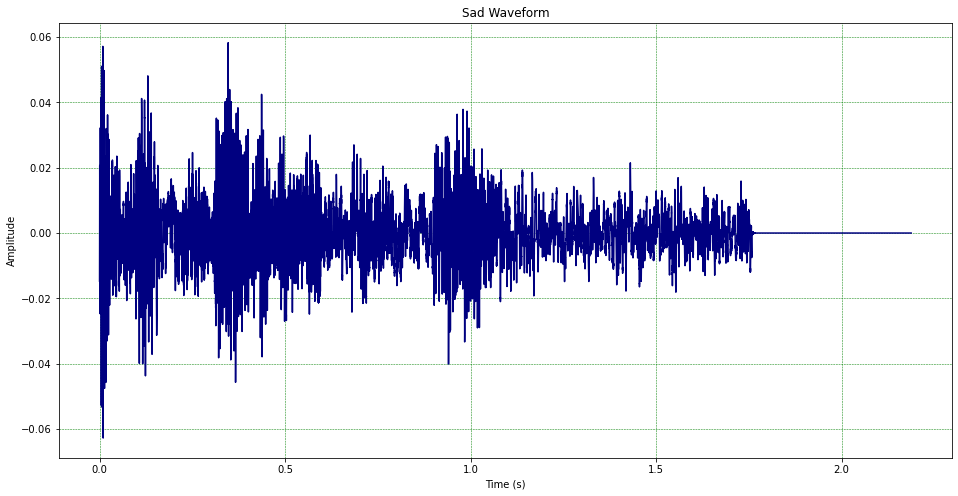

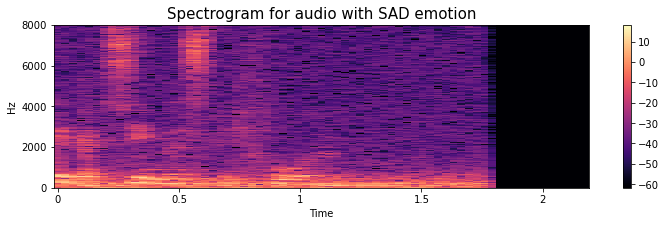

In [406]:
# SAD
audio,fs = load_audio(df,'SAD')
create_spectrogram(audio,fs,'SAD')
IPython.display.Audio(audio,rate=fs)

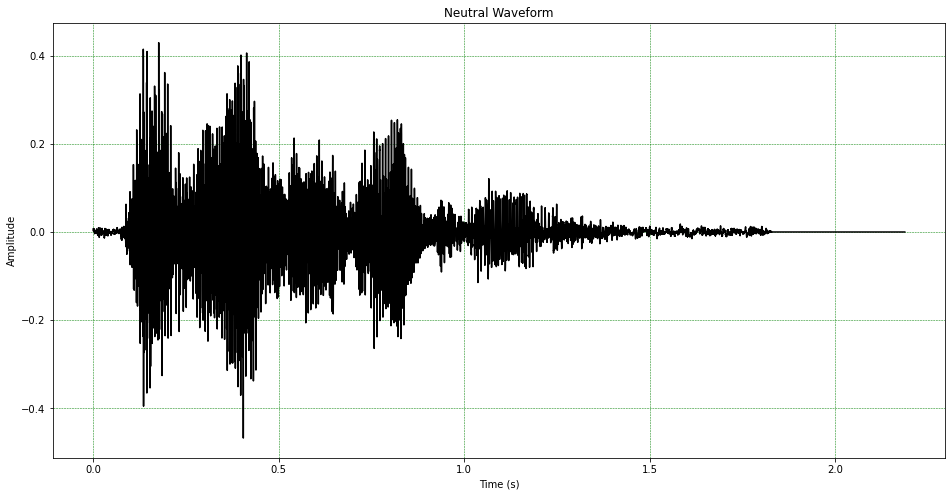

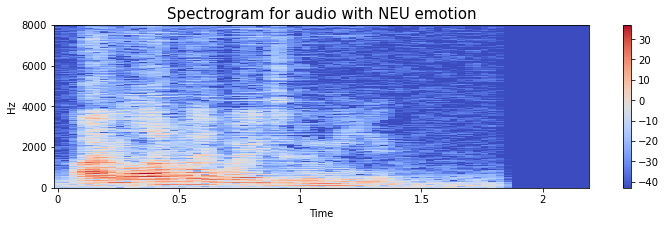

In [407]:
# NEUTRAL
audio,fs = load_audio(df,'NEU')
create_spectrogram(audio,fs,'NEU')
IPython.display.Audio(audio,rate=fs)


In [238]:
def pad(list,mel_spectrogram=False,max_len=None):
    padded_list = []
    if not mel_spectrogram:
        if max_len == None:
            max_len =  max([i.size for i in list])
        for l in list:
            if not l.size >= max_len:
                padded_list.append(np.pad(l, (0, max_len-l.size), 'constant'))
            else:
                padded_list.append(l[:max_len])
    else:
        if max_len == None:
            max_len =  max([i.shape[0] for i in list])
        for l in list:
            if not l.shape[0] >= max_len:
                padded_list.append(np.pad(l, [(0, max_len-l.shape[0]),(0,0)], mode='constant'))
            else:
                padded_list.append(l[:max_len,:])
    return padded_list,max_len


In [108]:
df.to_numpy().shape

(7442, 2)

In [109]:
df['data'][2][0].shape

(34701,)

In [110]:
audio = df['data'][0][0]
fs = df['data'][0][1]
mel = librosa.feature.melspectrogram(y=audio, sr=fs, n_fft=1024,n_mels=128).T
mel_db = librosa.power_to_db(mel, ref=np.max)
mel.shape

(72, 128)

In [178]:
for data,fs in df['data'].to_numpy():
    print(data)

[0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 6.1035156e-05 0.0000000e+00
 0.0000000e+00]
[ 9.1552734e-04  1.3122559e-03  1.5869141e-03 ... -3.0517578e-05
  0.0000000e+00  0.0000000e+00]
[ 8.0261230e-03  8.4533691e-03  8.3618164e-03 ... -9.1552734e-05
 -9.1552734e-05 -3.0517578e-05]
[-0.0043335  -0.00326538 -0.00302124 ... -0.00012207 -0.00018311
 -0.00021362]
[ 0.00241089  0.00137329  0.00131226 ... -0.00036621 -0.00054932
 -0.00024414]
[0.0027771  0.00241089 0.00234985 ... 0.         0.         0.        ]
[-3.0517578e-05 -6.4086914e-04  3.0517578e-04 ... -6.1035156e-05
  9.1552734e-05  0.0000000e+00]
[-0.00143433  0.00027466  0.00064087 ...  0.          0.
  0.        ]
[0.00338745 0.00366211 0.0038147  ... 0.         0.         0.        ]
[ 6.7443848e-03  6.1645508e-03  4.7607422e-03 ... -3.0517578e-05
 -3.0517578e-05 -3.0517578e-05]
[-0.00228882 -0.00204468 -0.00180054 ...  0.          0.
  0.        ]
[0.00585938 0.00494385 0.00592041 ... 0.         0.         0.        ]
[-0.0

In [168]:
X = np.array([x for x,_ in df['data']],dtype=object) 
X[0]

array([0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 6.1035156e-05,
       0.0000000e+00, 0.0000000e+00], dtype=float32)

In [456]:
X_trainval, X_test, y_trainval, y_test = train_test_split(df['data'].to_numpy(), np.array(labels), test_size=0.3, random_state=42,stratify=labels)
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.05, random_state=42,stratify=y_trainval)

In [457]:
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)
y_val = le.transform(y_val)

In [444]:
y_val.shape

(261,)

In [445]:
X_train[1][0].shape

(35000,)

In [265]:
for data in X_train:
    print(data)

[array([-0.00479126, -0.00527954, -0.00588989, ..., -0.00085449,
       -0.00085449, -0.00085449], dtype=float32), 16000]
[array([-2.1057129e-03, -1.2512207e-03, -1.6784668e-03, ...,
        0.0000000e+00,  3.0517578e-05,  0.0000000e+00], dtype=float32), 16000]
[array([ 8.0261230e-03,  7.5683594e-03,  7.1105957e-03, ...,
       -3.0517578e-05,  0.0000000e+00,  3.0517578e-05], dtype=float32), 16000]
[array([0.00241089, 0.00216675, 0.00234985, ..., 0.        , 0.        ,
       0.        ], dtype=float32), 16000]
[array([-0.00061035, -0.00067139, -0.00167847, ..., -0.00021362,
       -0.00030518, -0.00042725], dtype=float32), 16000]
[array([-0.00604248, -0.00534058, -0.0055542 , ...,  0.        ,
        0.        ,  0.        ], dtype=float32), 16000]
[array([-0.00296021, -0.00415039, -0.0039978 , ..., -0.00039673,
        0.00024414,  0.        ], dtype=float32), 16000]
[array([0.01077271, 0.00976562, 0.0090332 , ..., 0.00033569, 0.00036621,
       0.00039673], dtype=float32), 16000]


In [411]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
def create_feature_space(X,y=None,mel_spectrogram=False,training = False, max_len_zcr=None,max_len_en=None,max_len_mfccs=None,max_len_mel=None,clf=None,mean=None,stddev=None):
    # labels = []
    if not mel_spectrogram: # time/freq domain feature space
        feature_space = []
        zcrs=[]
        energies=[]
        mfccs=[]
        rolloff=[]
        # lfccs = []
        # transform = transforms.LFCC(
        # speckwargs={"n_fft": 400, "hop_length": 512, "center": False})
        for i,data in enumerate(X):
            # audio = np.array(data[0][0],dtype='float')
            audio = data[0]
            fs = data[1]
            # zero_crosses = np.nonzero(np.diff(audio > 0))[0]
            # zcr = zero_crosses.size/len(audio) # zero crossing rate

            # zero crossing rate
            # zcr=np.squeeze(librosa.feature.zero_crossing_rate(audio,frame_length=2048,hop_length=512))
            zcr=np.mean(librosa.feature.zero_crossing_rate(audio,frame_length=2048,hop_length=512).T,axis=0)

            # print(zcr.shape)
            zcrs.append(zcr)

            # normalized energy
            # energy=np.squeeze(librosa.feature.rms(y=audio,frame_length=2048,hop_length=512))
            # energy = np.array([sum(audio[j:j+2048]**2)/2048 for j in range(0, len(audio), 512)])
            # print(energy.shape)
            energy=np.mean(librosa.feature.rms(y=audio,frame_length=2048,hop_length=512).T,axis=0)
            energies.append(energy)

            # mel frequency cepstral coefficient (MFCC)
            mfcc=np.ravel(librosa.feature.mfcc(y=audio,sr=fs).T)
            # print(mfcc.shape)
            mfccs.append(mfcc)

            roll = np.squeeze(librosa.feature.spectral_rolloff(y=audio, sr=fs,hop_length=512))
            rolloff.append(roll)
            
            # lfcc = transform(tf.convert_to_tensor(audio)[0])
            # lfccs.append(lfcc.numpy())
            
            # feature_space.append(np.concatenate((zcr,energy,mfcc), axis=None))
            # labels.append(data[1])

            if i%1000==0:
                print(f'audio #{i} checkpoint')

        # max_len = max([len(i) for i in zcrs]) # find the longest list of scr to pad the others until they have equal length
        # if not training:
        #     zcrs,_ = pad(zcrs,max_len=max_len_zcr)
        #     energies,_ = pad(energies,max_len=max_len_en)
        #     mfccs,_ = pad(mfccs,max_len=max_len_mfccs)
        # else:
        #     zcrs,max_len_z = pad(zcrs)
        #     energies,max_len_e = pad(energies)
        #     mfccs,max_len_m = pad(mfccs)

        # lfccs = pad(lfccs)

        for i in range(X.shape[0]):
            # feature_space.append(np.concatenate((zcrs[i],energies[i],mfccs[i],lfccs[i]), axis=None))
            feature_space.append(np.concatenate((zcrs[i],energies[i],mfccs[i],rolloff[i]), axis=None))

        # labels = np.array(labels)
        feature_space = np.array(feature_space)
        # if training:
            # clf = LinearDiscriminantAnalysis(n_components=5).fit(feature_space,y)
            # feature_space=clf.transform(feature_space)
            # return feature_space,max_len_z,max_len_e,max_len_m,clf
            # return feature_space,clf
        # else:
            # feature_space=clf.transform(feature_space)
        return feature_space
    else:
        mels=[]
        for i,data in enumerate(X):
            audio = data[0]
            fs = data[1]
            mel = librosa.feature.melspectrogram(y=audio, sr=fs, n_fft=2048,n_mels=128).T
            # mel = librosa.feature.melspectrogram(y=audio, sr=fs, n_fft=1024,n_mels=128)
            # mel_db = librosa.power_to_db(mel, ref=np.max)
            mels.append(mel)
            # labels.append(data[1])
            if i%1000==0:
                print(f'audio #{i} checkpoint')
        mels=np.array(mels)
        # if training:
            # mels,max_len_mels = pad(mels,mel_spectrogram=True)
            # mean_value = np.mean(mels,axis=0)
            # std_value = np.std(mels,axis=0)
            # norm_mels = (mels - mean_value) / std_value
            # return norm_mels,max_len_mels,mean_value,std_value
            # return norm_mels,mean_value,std_value

        # else:
            # mels,_ = pad(mels,mel_spectrogram=True,max_len=max_len_mel)
            # norm_mels = (mels - mean) / stddev
        return mels



In [412]:
# space,z,e,m,clf = create_feature_space(X_train,y=y_train,training=True)
space = create_feature_space(X_train,y=y_train,training=True)

audio #0 checkpoint
audio #1000 checkpoint
audio #2000 checkpoint
audio #3000 checkpoint
audio #4000 checkpoint


In [413]:
space_val = create_feature_space(X_val)

audio #0 checkpoint


In [414]:
space_test = create_feature_space(X_test)

audio #0 checkpoint
audio #1000 checkpoint
audio #2000 checkpoint


In [416]:
space.shape

(4948, 1587)

In [417]:
space_test.shape

(2233, 1587)

In [418]:
X_test.shape

(2233,)

In [419]:
X_val.shape

(261,)

In [420]:
space_val.shape

(261, 1587)

In [421]:
y_val.shape

(261,)

In [422]:
X_train = space
X_test = space_test
X_val = space_val

In [341]:
mels= create_feature_space(X_train,mel_spectrogram=True)

ParameterError: Audio data must be of type numpy.ndarray

In [268]:
mels_test = create_feature_space(X_test,mel_spectrogram=True)
mels_val = create_feature_space(X_val,mel_spectrogram=True)

audio #0 checkpoint
audio #1000 checkpoint
audio #2000 checkpoint
audio #0 checkpoint


In [112]:
# mels,labels2 =create_feature_space(df,mel_spectrogram=True)

audio #0 checkpoint
audio #1000 checkpoint
audio #2000 checkpoint
audio #3000 checkpoint
audio #4000 checkpoint
audio #5000 checkpoint
audio #6000 checkpoint
audio #7000 checkpoint


In [115]:
# len(labels2)

7442

In [270]:
mels[1].shape

(156, 128)

In [40]:
# le = LabelEncoder()
# labels1 = le.fit_transform(labels1)
# labels1


array([0, 1, 2, ..., 3, 4, 5], dtype=int64)

In [117]:
# le = LabelEncoder()
# labels2 = le.fit_transform(labels2)
# labels2


array([0, 1, 2, ..., 3, 4, 5], dtype=int64)

In [42]:
# np.count_nonzero(labels1==labels2) #;))))))))))))

7442

In [43]:
# len(labels)

7442

In [242]:
# len(space)
mels[0].shape

(156, 128)

In [271]:
X_train = np.array(mels)
X_test = np.array(mels_test)
X_val = np.array(mels_val)

# labels2.shape

In [245]:
mels.shape

(4948, 156, 128)

In [121]:
# X_trainval, X_test, y_trainval, y_test = train_test_split(mels, labels2, test_size=0.3, random_state=42,stratify=labels2)


In [88]:
# X_trainval, X_test, y_trainval, y_test = train_test_split(space, labels1, test_size=0.3, random_state=42,stratify=labels1)

In [122]:
# X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.05, random_state=42,stratify=y_trainval)

In [423]:
len(X_train)

4948

In [42]:
# ss=StandardScaler()
# X_train=ss.fit_transform(X_train)
# X_test=ss.transform(X_test)
# X_val=ss.transform(X_val)

In [424]:
earlystopper = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1, monitor='val_acc')
checkpointer = tf.keras.callbacks.ModelCheckpoint('models\\first_model.h5', verbose=1, monitor='val_acc',mode='max', save_best_only=True)
# checkpointer = tf.keras.callbacks.ModelCheckpoint('models\\first_model.h5', verbose=1, save_best_only=True)

    

In [248]:
y_train.shape

(4948,)

In [425]:
X_train.shape

(4948, 1587)

In [426]:
y_train

array([0, 5, 2, ..., 0, 1, 3], dtype=int64)

In [427]:
# X_train = np.array(X_train)
# X_val = np.array(X_val)
# y_train = np.array(y_train)
# y_val = np.array(y_val)


In [428]:
# X_train = np.expand_dims(X_train,axis=2)
X_train.shape

(4948, 1587)

In [429]:
# X_val = np.expand_dims(X_val,axis=2)
X_val.shape

(261, 1587)

In [430]:
# y_train = y_train.reshape(-1,1)
y_train.shape

(4948,)

In [431]:
# y_val = y_val.reshape(-1,1)
y_val.shape

(261,)

In [458]:
X_trainn = np.array(np.array([x for x,_ in X_train]))

In [459]:
X_testt = np.array(np.array([x for x,_ in X_test]))
X_vall = np.array(np.array([x for x,_ in X_val]))

In [460]:
X_trainn

array([[-0.00875854, -0.03668213,  0.00076294, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.01199341,  0.00610352,  0.00482178, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.00234985,  0.00366211,  0.00375366, ...,  0.00305176,
         0.0027771 ,  0.00247192],
       ...,
       [-0.05221558, -0.05996704, -0.06439209, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.0027771 ,  0.00222778,  0.00323486, ..., -0.00106812,
        -0.00094604, -0.00091553],
       [ 0.00320435,  0.03237915,  0.02774048, ...,  0.        ,
         0.        ,  0.        ]], dtype=float32)

In [461]:
sc=StandardScaler()
X_trainn=sc.fit_transform(X_trainn)
X_testt=sc.transform(X_testt)
X_vall=sc.transform(X_vall)

In [434]:
X_train=np.expand_dims(X_train,axis=2)
X_val=np.expand_dims(X_val,axis=2)
X_test=np.expand_dims(X_test,axis=2)
X_train.shape, X_test.shape, X_val.shape

((4948, 1587, 1), (2233, 1587, 1), (261, 1587, 1))

In [546]:
early_stop=EarlyStopping(monitor='val_acc',mode='auto',patience=20,restore_best_weights=True)
lr_reduction=ReduceLROnPlateau(monitor='val_acc',patience=5,verbose=1,factor=0.5,min_lr=0.000001)

In [734]:
def extract_features(audio):
    result = np.array([])
    
    zcr=np.mean(librosa.feature.zero_crossing_rate(audio,frame_length=2048,hop_length=128).T,axis=0)
    # zcr=np.squeeze(librosa.feature.zero_crossing_rate(audio,frame_length=2048,hop_length=256))

    result = np.hstack((result,zcr))
    
    rms = np.mean(librosa.feature.rms(y=audio,frame_length=2048,hop_length=128).T ,axis=0)
    result = np.hstack((result, rms))

    rolloff = np.mean(librosa.feature.spectral_rolloff(y=audio, sr=16000,hop_length=128).T,axis=0)
    result = np.hstack((result, rolloff))

    # stft = np.abs(librosa.stft(audio))
    # chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=16000).T, axis=0)
    # result = np.hstack((result, chroma_stft))

    # mfcc = np.mean(librosa.feature.mfcc(y=audio, sr=16000).T, axis=0)
    mfcc = np.ravel(librosa.feature.mfcc(y=audio, sr=16000).T)
    result = np.hstack((result, mfcc))

    # delta_mfcc = np.mean(librosa.feature.delta(mfcc).T,axis=0)
    # result = np.hstack((result, delta_mfcc))

    # delta2_mfcc = np.mean(librosa.feature.delta(mfcc, order=2).T,axis=0)
    # result = np.hstack((result, delta2_mfcc))


    # Extract chroma features
    # chroma = librosa.feature.chroma_stft(y=audio, sr=16000)
    # chroma_energy = np.mean(chroma, axis=1)
    # # chroma_deviation = np.std(chroma, axis=1)
    # result = np.hstack((result, chroma_energy))
    # result = np.hstack((result, chroma_deviation))


    # pitch, magnitudes = librosa.core.piptrack(y=audio, sr=16000)
    # pitch_mean = np.mean(pitch, axis=0)
    # pitch_std = np.std(pitch, axis=0)
    # pitch_range = np.max(pitch, axis=0) - np.min(pitch, axis=0)
    # result = np.hstack((result, pitch_mean))
    # result = np.hstack((result, pitch_std))
    # result = np.hstack((result, pitch_range))



    

    return result

In [719]:
X_trainn.shape

(4948, 35000)

In [465]:
X_trainn[0]

array([-0.27127036, -1.1559387 ,  0.02684566, ...,  0.019997  ,
        0.0263293 ,  0.03102301], dtype=float32)

In [735]:
features_train = []
features_test = []
features_val = []

for i in range(X_trainn.shape[0]):
    features_train.append(extract_features(X_trainn[i]))
for i in range(X_testt.shape[0]):
    features_test.append(extract_features(X_testt[i]))
for i in range(X_vall.shape[0]):
    features_val.append(extract_features(X_vall[i]))


In [736]:
features_train = np.array(features_train)
features_test = np.array(features_test)
features_val = np.array(features_val)


In [705]:
# lda = LinearDiscriminantAnalysis(n_components=5).fit(features_train,y_train)
# features_trainn = lda.transform(features_train)
# features_testt = lda.transform(features_test)
# features_vall = lda.transform(features_val)
from sklearn.decomposition import PCA
pca = PCA(n_components=50)
features_trainn = pca.fit_transform(X_trainn)
features_testt = pca.transform(X_testt)
features_vall = pca.transform(X_vall)

In [737]:
features_val.shape,y_val.shape

((261, 1383), (261,))

In [746]:

# model=tf.keras.Sequential([
#     L.Conv1D(512,kernel_size=5, strides=1,padding='same', activation='relu',input_shape=(X_train.shape[1],1)),
#     L.BatchNormalization(),
#     L.MaxPool1D(pool_size=5,strides=2,padding='same'),
#     L.Conv1D(512,kernel_size=5, strides=1,padding='same', activation='relu'),
#     L.BatchNormalization(),
#     L.MaxPool1D(pool_size=5,strides=2,padding='same'),
#     # L.Conv1D(512,kernel_size=5,strides=1,padding='same',activation='relu'),
#     # L.BatchNormalization(),
#     # L.MaxPool1D(pool_size=5,strides=2,padding='same'),
#     L.Conv1D(256,kernel_size=5,strides=1,padding='same',activation='relu'),
#     L.BatchNormalization(),
#     L.MaxPool1D(pool_size=5,strides=2,padding='same'),
#     L.Conv1D(256,kernel_size=3,strides=1,padding='same',activation='relu'),
#     L.BatchNormalization(),
#     L.MaxPool1D(pool_size=5,strides=2,padding='same'),
#     L.Conv1D(128,kernel_size=3,strides=1,padding='same',activation='relu'),
#     L.BatchNormalization(),
#     L.MaxPool1D(pool_size=3,strides=2,padding='same'),
#     # L.Conv1D(128,kernel_size=3,strides=1,padding='same',activation='relu'),
#     # L.BatchNormalization(),
#     # L.MaxPool1D(pool_size=3,strides=2,padding='same'),
#     L.Flatten(),
#     L.Dropout(rate=0.2),

#     L.Dense(512,activation='relu'),
#     # L.Dense(512,activation='relu'),
#     L.BatchNormalization(),
#     L.Dense(6,activation='softmax')
# ])
# # model.compile(optimizer='adam',loss='categorical_crossentropy',metrics='accuracy')
# model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics='acc')
# model.summary()


model=tf.keras.Sequential([
    L.Conv1D(512,kernel_size=5, strides=1,padding='same', activation='relu',input_shape=(features_train.shape[1],1)),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=5,strides=2,padding='same'),
    L.Conv1D(512,kernel_size=5,strides=1,padding='same',activation='relu'),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=5,strides=2,padding='same'),
    L.Conv1D(256,kernel_size=5,strides=1,padding='same',activation='relu'),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=5,strides=2,padding='same'),
    L.Conv1D(256,kernel_size=3,strides=1,padding='same',activation='relu'),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=5,strides=2,padding='same'),
    L.Dropout(0.3),
    L.Conv1D(128,kernel_size=3,strides=1,padding='same',activation='relu'),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=3,strides=2,padding='same'),
    # L.LSTM(64,return_sequences=True),
    # L.LSTM(64),
    L.Flatten(),
    # L.Dense(512,activation='relu'),
    L.Dense(512,activation='relu'),
    L.BatchNormalization(),
    L.Dense(6,activation='softmax')
])
# model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics='accuracy')
# model.summary()


# model = tf.keras.Sequential()
# model.add(L.Conv1D(512, kernel_size=(5), activation='relu',strides=1,use_bias=True,bias_initializer="zeros",kernel_regularizer=l2(0),input_shape=(features_train.shape[1],1)))
# model.add(L.MaxPooling1D(pool_size=(5),strides=2))
# model.add(L.Dropout(0.4))

# model.add(L.Conv1D(512, kernel_size=(3), activation='relu',strides=1,use_bias=True,bias_initializer="zeros",kernel_regularizer=l2(0)))
# model.add(L.MaxPooling1D(pool_size=(5),strides=2))
# model.add(L.Dropout(0.4))

# model.add(L.Conv1D(128, kernel_size=(3), activation='relu',strides=1,use_bias=True,bias_initializer="zeros",kernel_regularizer=l2(0)))
# model.add(L.MaxPooling1D(pool_size=(5),strides=2))
# model.add(L.Dropout(0.4))

# model.add(L.Flatten())
# model.add(L.Dense(256, activation='relu'))
# model.add(L.Dropout(0.4))

# model.add(L.Dense(6, activation='softmax'))
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(loss='sparse_categorical_crossentropy', optimizer=opt ,metrics=['acc'])
model.summary()


Model: "sequential_120"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_378 (Conv1D)         (None, 1383, 512)         3072      
                                                                 
 batch_normalization_440 (Ba  (None, 1383, 512)        2048      
 tchNormalization)                                               
                                                                 
 max_pooling1d_369 (MaxPooli  (None, 692, 512)         0         
 ng1D)                                                           
                                                                 
 conv1d_379 (Conv1D)         (None, 692, 512)          1311232   
                                                                 
 batch_normalization_441 (Ba  (None, 692, 512)         2048      
 tchNormalization)                                               
                                                    

In [747]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout

early_stop=EarlyStopping(monitor='val_acc',mode='auto',patience=50,restore_best_weights=True)
lr_reduction=ReduceLROnPlateau(monitor='val_acc',patience=8,verbose=1,factor=0.75,min_lr=0.0000001)
# Define the model architecture
modelopt = Sequential()
modelopt.add(Conv1D(filters=32, kernel_size=5, activation='relu', input_shape=(features_train.shape[1], 1)))
modelopt.add(MaxPooling1D(pool_size=2,padding='same'))
# modelopt.add(BatchNormalization())
modelopt.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
modelopt.add(MaxPooling1D(pool_size=2,padding='same'))
# modelopt.add(BatchNormalization())
modelopt.add(Conv1D(filters=256, kernel_size=3, activation='relu'))
modelopt.add(MaxPooling1D(pool_size=2,padding='same'))
# modelopt.add(Conv1D(filters=256, kernel_size=3, activation='relu'))
# modelopt.add(MaxPooling1D(pool_size=2,padding='same'))
modelopt.add(LSTM(64, return_sequences=True))
modelopt.add(LSTM(64))
# modelopt.add(Dropout(0.5))
modelopt.add(Dense(256, activation='relu'))#, kernel_regularizer=tf.keras.regularizers.l1_l2(l1=0.01, l2=0.01)))
# modelopt.add(Dropout(0.5))
modelopt.add(Dense(6, activation='softmax'))

opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
modelopt.compile(loss='sparse_categorical_crossentropy', optimizer=opt ,metrics=['acc'])
modelopt.summary()

Model: "sequential_121"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_383 (Conv1D)         (None, 1379, 32)          192       
                                                                 
 max_pooling1d_374 (MaxPooli  (None, 690, 32)          0         
 ng1D)                                                           
                                                                 
 conv1d_384 (Conv1D)         (None, 688, 64)           6208      
                                                                 
 max_pooling1d_375 (MaxPooli  (None, 344, 64)          0         
 ng1D)                                                           
                                                                 
 conv1d_385 (Conv1D)         (None, 342, 256)          49408     
                                                                 
 max_pooling1d_376 (MaxPooli  (None, 171, 256)      

In [748]:
histopt = model.fit(features_train, y_train, batch_size=128, epochs=100, verbose=1, validation_data=(features_val, y_val), callbacks=[early_stop,lr_reduction])

Epoch 1/100
 1/39 [..............................] - ETA: 9:06 - loss: 2.3796 - acc: 0.1641

In [704]:
loss,accuracy=model.evaluate(features_test,y_test,verbose=0)
print(f'Test Loss: {loss}')
print(f'Test Accuracy: {accuracy}')

Test Loss: 1.7954295873641968
Test Accuracy: 0.4455888867378235


In [545]:
es = EarlyStopping(monitor='val_loss', verbose=1, patience=50)
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=2, min_lr=0.0001)

In [515]:
y_val.shape,features_val.shape

((261,), (261, 637))

In [493]:
hist = model.fit(features_train, y_train, batch_size=128, epochs=100, verbose=1, validation_data=(features_val, y_val), callbacks=[early_stop,lr_reduction])

Epoch 1/100
39/39 [==============================] - 23s 450ms/step - loss: 1.9096 - acc: 0.3013 - val_loss: 5.0133 - val_acc: 0.1724 - lr: 1.0000e-04
Epoch 2/100
39/39 [==============================] - 17s 433ms/step - loss: 1.7263 - acc: 0.3373 - val_loss: 2.0859 - val_acc: 0.2299 - lr: 1.0000e-04
Epoch 3/100
39/39 [==============================] - 17s 443ms/step - loss: 1.6632 - acc: 0.3559 - val_loss: 1.8614 - val_acc: 0.1724 - lr: 1.0000e-04
Epoch 4/100
39/39 [==============================] - 17s 430ms/step - loss: 1.6164 - acc: 0.3612 - val_loss: 1.6996 - val_acc: 0.2567 - lr: 1.0000e-04
Epoch 5/100
39/39 [==============================] - 17s 433ms/step - loss: 1.5683 - acc: 0.3775 - val_loss: 1.6211 - val_acc: 0.3333 - lr: 1.0000e-04
Epoch 6/100
39/39 [==============================] - 17s 426ms/step - loss: 1.5800 - acc: 0.3705 - val_loss: 1.5418 - val_acc: 0.3180 - lr: 1.0000e-04
Epoch 7/100
39/39 [==============================] - 17s 429ms/step - loss: 1.5425 - acc: 0.38

In [496]:
import plotly.express as px
fig=px.line(hist.history,y=['acc','val_acc'],
           labels={'index':'epoch','value':'acc'},
           title=f'According to the epoch accuracy and validation accuracy chart for the model')
fig.show()

In [502]:
fig=px.line(hist.history,y=['loss','val_loss'],
           labels={'index':'epoch','value':'loss'},
           title=f'According to the epoch loss and validation loss chart for the model')
fig.show()

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
conf=confusion_matrix(y_test,y_pred)
cm=pd.DataFrame(
    conf,index=[i for i in set(labels)],
    columns=[i for i in set(labels)]
)
plt.figure(figsize=(12,7))
ax=sns.heatmap(cm,annot=True,fmt='d')
ax.set_title(f'confusion matrix for model ')
plt.show()

In [516]:
hist2 = model.fit(features_train, y_train, batch_size=64, epochs=50, verbose=1, validation_data=(features_val, y_val), callbacks=[early_stop,lr_reduction])


Epoch 1/50
78/78 [==============================] - 167s 2s/step - loss: 1.9794 - acc: 0.2850 - val_loss: 2.4579 - val_acc: 0.2452 - lr: 1.0000e-04
Epoch 2/50
78/78 [==============================] - 167s 2s/step - loss: 1.7202 - acc: 0.3432 - val_loss: 1.9398 - val_acc: 0.2452 - lr: 1.0000e-04
Epoch 3/50
78/78 [==============================] - 169s 2s/step - loss: 1.6271 - acc: 0.3652 - val_loss: 1.7943 - val_acc: 0.2375 - lr: 1.0000e-04
Epoch 4/50
78/78 [==============================] - 167s 2s/step - loss: 1.5450 - acc: 0.3884 - val_loss: 1.7942 - val_acc: 0.2912 - lr: 1.0000e-04
Epoch 5/50
78/78 [==============================] - 170s 2s/step - loss: 1.5145 - acc: 0.4014 - val_loss: 1.4952 - val_acc: 0.3602 - lr: 1.0000e-04
Epoch 6/50
78/78 [==============================] - 163s 2s/step - loss: 1.4731 - acc: 0.4101 - val_loss: 1.5317 - val_acc: 0.3602 - lr: 1.0000e-04
Epoch 7/50
78/78 [==============================] - 163s 2s/step - loss: 1.4392 - acc: 0.4169 - val_loss: 1.5331

In [517]:
fig=px.line(hist2.history,y=['acc','val_acc'],
           labels={'index':'epoch','value':'acc'},
           title=f'According to the epoch accuracy and validation accuracy chart for the model')
fig.show()

In [518]:
fig=px.line(hist2.history,y=['loss','val_loss'],
           labels={'index':'epoch','value':'loss'},
           title=f'According to the epoch loss and validation loss chart for the model')
fig.show()

In [519]:
loss,accuracy=model.evaluate(features_test,y_test,verbose=0)
print(f'Test Loss: {loss}')
print(f'Test Accuracy: {accuracy}')

Test Loss: 1.3888615369796753
Test Accuracy: 0.4455888867378235


70/70 [==============================] - 14s 192ms/step


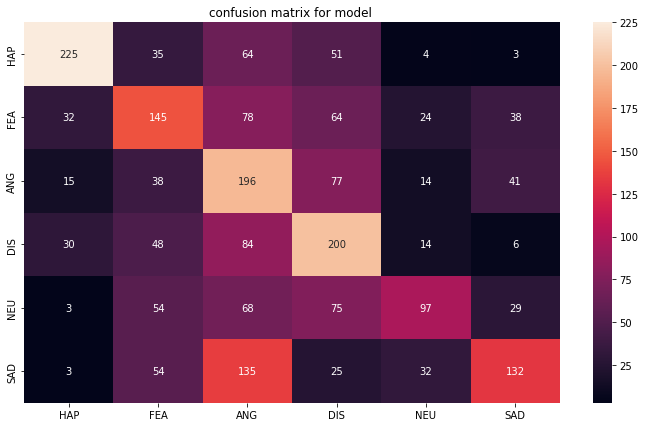

In [521]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
y_pred = model.predict(features_test)
y_pred = np.argmax(y_pred, axis=1)
conf=confusion_matrix(y_test,y_pred)
cm=pd.DataFrame(
    conf,index=[i for i in set(labels)],
    columns=[i for i in set(labels)]
)
plt.figure(figsize=(12,7))
ax=sns.heatmap(cm,annot=True,fmt='d')
ax.set_title(f'confusion matrix for model ')
plt.show()

In [124]:
print(model.evaluate(X_test,y_test))

70/70 [==============================] - 1s 7ms/step - loss: 0.9139 - accuracy: 0.7971
[0.9138697981834412, 0.7971339225769043]


In [125]:
y_val[0]

5

In [126]:
X_train.shape

(4948, 5)

In [127]:
# predicting on test data.
yhat = model.predict(X_test)
classes_pred=np.argmax(yhat,axis=1)
# y_pred = encoder.inverse_transform(pred_test)

# y_test = encoder.inverse_transform(y_test)
classes_pred

70/70 [==============================] - 1s 6ms/step


array([5, 5, 0, ..., 4, 0, 5], dtype=int64)

In [128]:
y_test

array([5, 5, 0, ..., 4, 0, 5], dtype=int64)

In [129]:
classes_pred.shape

(2233,)

In [130]:
accuracy = np.count_nonzero(y_test == classes_pred)/y_test.shape[0]
accuracy

0.7971339005821765

In [124]:
X_train.shape

(4948, 157, 128)

In [276]:
X_test[0].shape

(156, 128)

In [277]:
model2D=tf.keras.Sequential([
    L.Conv2D(32,kernel_size=5, strides=1,padding='same', activation='relu',kernel_regularizer=l1_l2(l1=0.01, l2=0.01),input_shape=(X_train.shape[1],X_train.shape[2],1)),
    L.BatchNormalization(),
    L.MaxPool2D(pool_size=5,strides=2,padding='same'),
    L.Conv2D(64,kernel_size=5,strides=1,padding='same',activation='relu',kernel_regularizer=l1_l2(l1=0.01, l2=0.01)),
    L.BatchNormalization(),
    L.MaxPool2D(pool_size=5,strides=2,padding='same'),
    # L.Conv2D(256,kernel_size=5,strides=1,padding='same',activation='relu'),
    L.Conv2D(128,kernel_size=5,strides=1,padding='same',activation='relu',kernel_regularizer=l1_l2(l1=0.01, l2=0.01)),
    L.BatchNormalization(),
    L.MaxPool2D(pool_size=3,strides=2,padding='same'),
    L.Conv2D(128,kernel_size=5,strides=1,padding='same',activation='relu',kernel_regularizer=l1_l2(l1=0.01, l2=0.01)),
    # L.BatchNormalization(),
    # L.MaxPool2D(pool_size=3,strides=2,padding='same'),

    # L.Conv2D(256,kernel_size=3,strides=1,padding='same',activation='relu'),
    # L.BatchNormalization(),
    # L.MaxPool2D(pool_size=5,strides=2,padding='same'),
    # L.Conv2D(128,kernel_size=3,strides=1,padding='same',activation='relu'),
    # L.BatchNormalization(),
    # L.GlobalAveragePooling2D(),

    
    L.Flatten(),
    # L.Dropout(rate=0.1),
    # L.Dense(512,activation='relu'),
    L.Dense(128,activation='relu'),
    # L.BatchNormalization(),
    L.Dense(64,activation='relu'),
    # L.BatchNormalization(),
    L.Dense(6,activation='softmax')
])
# model.compile(optimizer='adam',loss='categorical_crossentropy',metrics='accuracy')
model2D.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics='acc')
model2D.summary()

Model: "sequential_35"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_101 (Conv2D)         (None, 156, 128, 32)      832       
                                                                 
 batch_normalization_174 (Ba  (None, 156, 128, 32)     128       
 tchNormalization)                                               
                                                                 
 max_pooling2d_77 (MaxPoolin  (None, 78, 64, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_102 (Conv2D)         (None, 78, 64, 64)        51264     
                                                                 
 batch_normalization_175 (Ba  (None, 78, 64, 64)       256       
 tchNormalization)                                               
                                                     

In [278]:
X_train.shape

(4948, 156, 128)

In [279]:
y_train.shape

(4948,)

In [280]:
X_val.shape

(261, 156, 128)

In [281]:
y_val.shape

(261,)

In [282]:
history = model2D.fit(X_train, y_train, batch_size=128, epochs=100, verbose=1, validation_data=(X_val, y_val), callbacks = [earlystopper, checkpointer])

Epoch 1/100
39/39 [==============================] - ETA: 0s - loss: 71.1871 - acc: 0.3213
Epoch 1: val_acc improved from -inf to 0.17241, saving model to models\first_model.h5
39/39 [==============================] - 301s 8s/step - loss: 71.1871 - acc: 0.3213 - val_loss: 29.3060 - val_acc: 0.1724
Epoch 2/100
39/39 [==============================] - ETA: 0s - loss: 14.7697 - acc: 0.3537
Epoch 2: val_acc did not improve from 0.17241
39/39 [==============================] - 290s 7s/step - loss: 14.7697 - acc: 0.3537 - val_loss: 10.7989 - val_acc: 0.1724
Epoch 3/100
33/39 [========================>.....] - ETA: 42s - loss: 8.1239 - acc: 0.3274

KeyboardInterrupt: 